In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import warnings
warnings.filterwarnings('ignore')

# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define paths and constants
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
print("Classes:", classes)


Classes: ['lung_aca', 'lung_n', 'lung_scc']


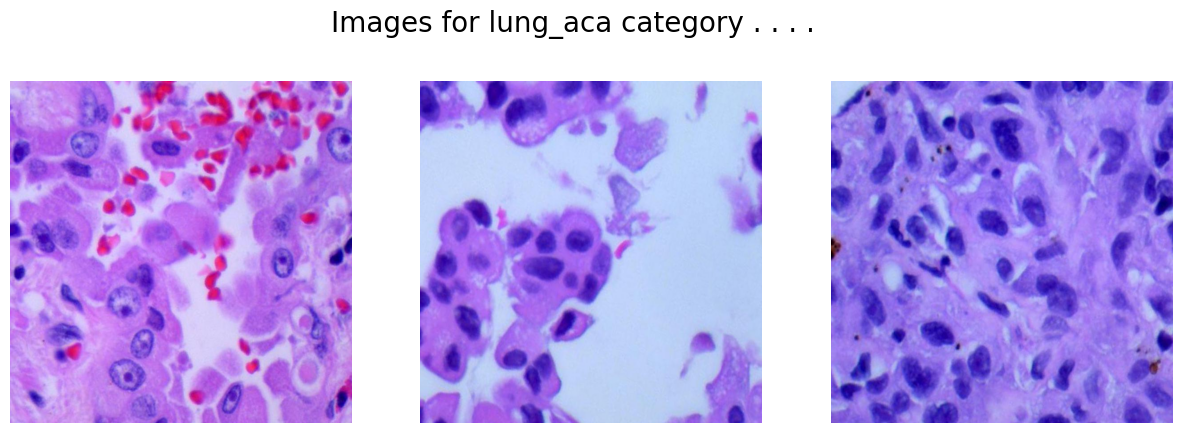

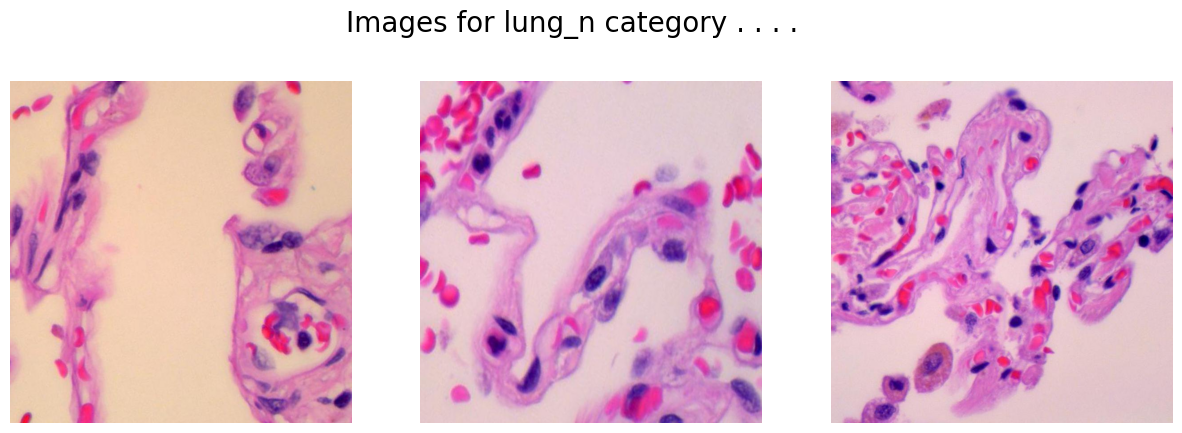

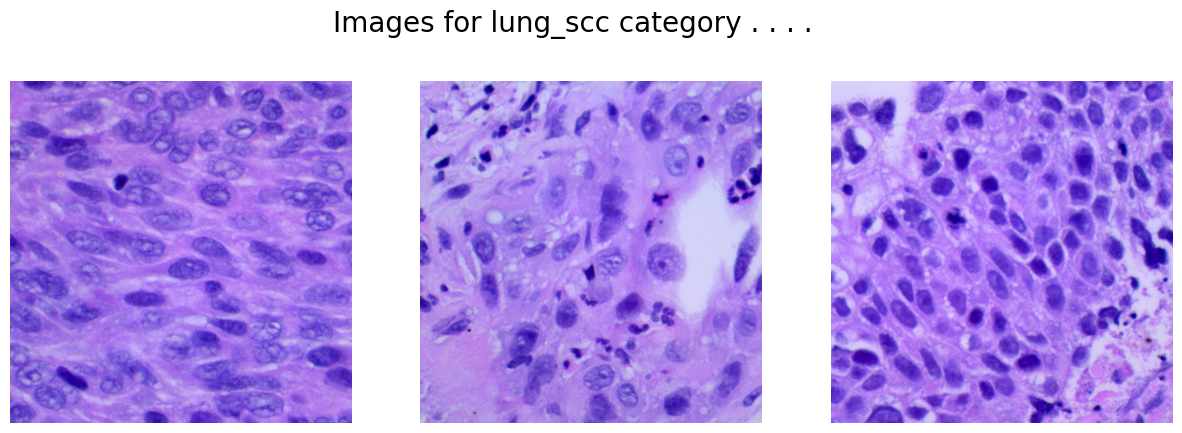

In [4]:
# Display sample images
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [5]:
# Define constants
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [6]:
# Create a custom dataset class
class LungImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
# Load and preprocess images
X = []
Y = []
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
Y = np.asarray(Y)


In [8]:
# Split data
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=SPLIT, random_state=2022)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 12000, Validation samples: 3000


In [9]:
# Define transformations with EfficientNet-specific preprocessing
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Create dataset objects
train_dataset = LungImageDataset(X_train, Y_train, transform=train_transform)
val_dataset = LungImageDataset(X_val, Y_val, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the model class using EfficientNet
class LungCancerClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LungCancerClassifier, self).__init__()
        # Load pre-trained EfficientNet B0
        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze base layers
        for param in list(self.efficientnet.parameters())[:-30]:  # Keep the last few layers trainable
            param.requires_grad = False
            
        # Replace the classifier
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove original classifier
        
        # Add custom classifier with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.efficientnet(x)
        x = self.classifier(x)
        return x

In [13]:
# Initialize model, loss function, and optimizer
model = LungCancerClassifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\verma/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:20<00:00, 1.02MB/s]


In [14]:
# Learning rate scheduler with warmup
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.3
)

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        # Ensure labels are long type (required for CrossEntropyLoss)
        labels = labels.long().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [19]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Ensure labels are long type (required for CrossEntropyLoss)
            labels = labels.long().to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
# Training loop with improved tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 3

print("Starting training...")
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    #Save the best model and check for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_lung_cancer_efficientnet_model.pth')
        print(f"Model saved with validation accuracy: {val_acc:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    # Stop if accuracy is high enough
    if val_acc > 0.90:
        print("\nValidation accuracy has reached up to 90%, stopping further training.")
        break

Starting training...
Epoch 1/10
Train Loss: 0.1604, Train Acc: 0.9402
Val Loss: 0.1151, Val Acc: 0.9577
Epoch 2/10
Train Loss: 0.1245, Train Acc: 0.9539
Val Loss: 0.0820, Val Acc: 0.9710
Epoch 3/10
Train Loss: 0.1051, Train Acc: 0.9617
Val Loss: 0.0725, Val Acc: 0.9743
Epoch 4/10
Train Loss: 0.0923, Train Acc: 0.9663
Val Loss: 0.0572, Val Acc: 0.9787
Epoch 5/10
Train Loss: 0.0750, Train Acc: 0.9717
Val Loss: 0.0444, Val Acc: 0.9823
Epoch 6/10
Train Loss: 0.0670, Train Acc: 0.9763
Val Loss: 0.0373, Val Acc: 0.9837
Epoch 7/10
Train Loss: 0.0604, Train Acc: 0.9778
Val Loss: 0.0369, Val Acc: 0.9850
Epoch 8/10
Train Loss: 0.0562, Train Acc: 0.9801
Val Loss: 0.0263, Val Acc: 0.9917
Epoch 9/10
Train Loss: 0.0513, Train Acc: 0.9808
Val Loss: 0.0228, Val Acc: 0.9917
Epoch 10/10
Train Loss: 0.0475, Train Acc: 0.9838
Val Loss: 0.0219, Val Acc: 0.9907


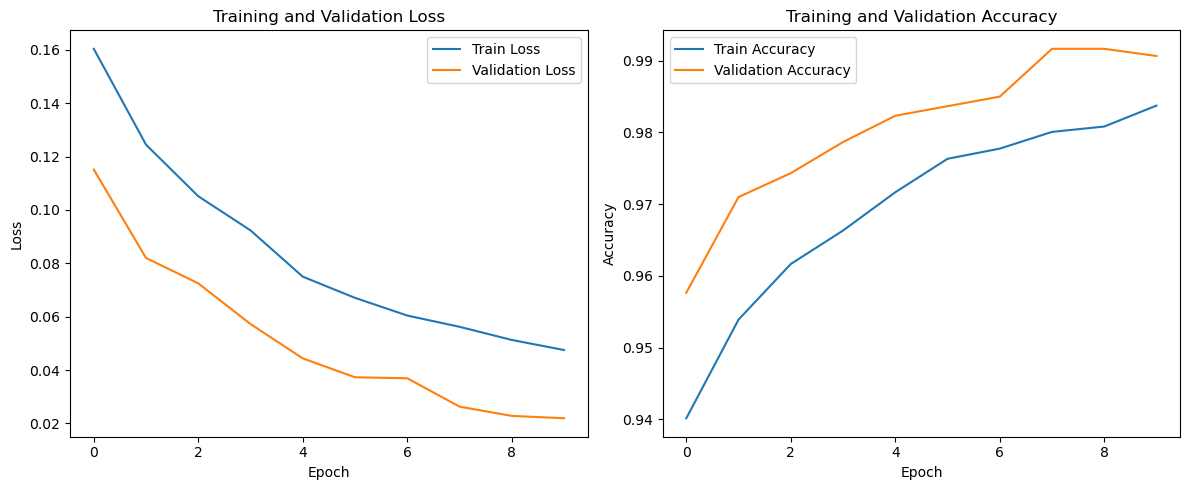

In [23]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_lung_cancer_efficientnet_model.pth'))

<All keys matched successfully>

In [25]:
# Final evaluation
_, final_val_acc, final_preds, final_labels = validate_epoch(model, val_loader, criterion, device)
print(f"Final validation accuracy: {final_val_acc:.4f}")

Final validation accuracy: 0.9377


In [26]:
# Confusion matrix
conf_matrix = metrics.confusion_matrix(final_labels, final_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[892   9  86]
 [  0 977   0]
 [ 92   0 944]]


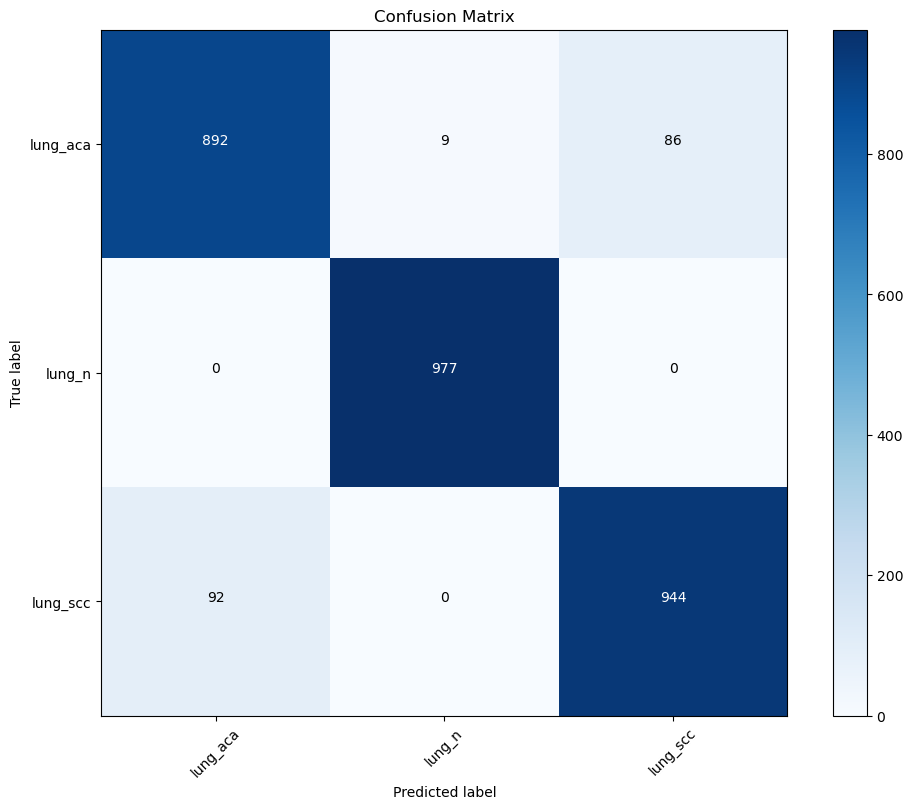

In [27]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations to confusion matrix
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
# Classification report
print("\nClassification Report:")
print(metrics.classification_report(final_labels, final_preds, target_names=classes))



Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.91      0.90      0.91       987
      lung_n       0.99      1.00      1.00       977
    lung_scc       0.92      0.91      0.91      1036

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [29]:
# Get per-class accuracy
class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class {classes[i]} accuracy: {acc:.4f}")

Class lung_aca accuracy: 0.9037
Class lung_n accuracy: 1.0000
Class lung_scc accuracy: 0.9112


In [30]:
# Save the full model
model_path = 'lung_cancer_efficientnet_full.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'classes': classes,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'best_val_acc': best_val_acc
}, model_path)

print(f"Full model saved to {model_path}")

Full model saved to lung_cancer_efficientnet_full.pth


In [31]:
# Creating a function for inference on new images
def predict_image(model, image_path, transform, device, classes):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Apply transforms
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Get the predicted class and probability
    pred_class = classes[predicted.item()]
    pred_prob = probs[0][predicted.item()].item()
    
    return pred_class, pred_prob, probs.cpu().numpy()[0]

print("Example of how to use the model for inference:")
print("""
# Load the saved model
loaded_model = LungCancerClassifier(num_classes=len(classes)).to(device)
checkpoint = torch.load('lung_cancer_efficientnet_full.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Predict on a new image
pred_class, pred_prob, all_probs = predict_image(loaded_model, 'path_to_new_image.jpeg', val_transform, device, classes)
print(f"Predicted class: {pred_class} with probability: {pred_prob:.4f}")
""")

Example of how to use the model for inference:

# Load the saved model
loaded_model = LungCancerClassifier(num_classes=len(classes)).to(device)
checkpoint = torch.load('lung_cancer_efficientnet_full.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Predict on a new image
pred_class, pred_prob, all_probs = predict_image(loaded_model, 'path_to_new_image.jpeg', val_transform, device, classes)
print(f"Predicted class: {pred_class} with probability: {pred_prob:.4f}")

